In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Reading TV Time CSV Data
tvshows_df = pd.read_csv("Data/tvtimeshows.csv")
tvshows_df.head()

,id,name,followers,nb_rates,runtime,number_of_seasons,network,mean_rate,poster_image,seasons
0,288128,X-Ray & Vav,230,10,9,2,Rooster Teeth,4.20,https://dg31sz3gwrwan.cloudfront.net/poster/28...,"[{'number': 1, 'nb_episodes': 4}, {'number': 2..."
1,313803,Sister's Slam Dunk,1298,100,80,2,KBS TV2,4.25,https://dg31sz3gwrwan.cloudfront.net/poster/31...,"[{'number': 1, 'nb_episodes': 33}, {'number': ..."
2,325462,Reverse,270,15,60,1,Tokyo Broadcasting System,4.63,https://dg31sz3gwrwan.cloudfront.net/poster/32...,"[{'number': 1, 'nb_episodes': 10}]"
3,325198,Frame Arms Girl,900,24,25,1,Tokyo MX,3.54,https://dg31sz3gwrwan.cloudfront.net/poster/32...,"[{'number': 1, 'nb_episodes': 12}]"
4,349743,Mr Inbetween,7123,118,25,2,FX,4.42,https://dg31sz3gwrwan.cloudfront.net/poster/34...,"[{'number': 1, 'nb_episodes': 6}, {'number': 2..."


In [3]:
# Reading All Episodes CSV Data
episode_df = pd.read_csv("Data/all_episodes.csv")
episode_df.head()

,show_id,episode_id,time,episode,title,description,rating,times_watched,mood-good,mood-fun,mood-wow,mood-sad,mood-so-so,mood-bad
0,315103,5697528,2016-10-05T03:00,S01E01,Idiots with Numbers!,Idiots with Numbers! (S01E01) is the first epi...,9.48,12307.0,175.0,388.0,136.0,1.0,16.0,3.0
1,315103,5774664,2016-10-12T03:00,S01E02,The Inmates Are Stupid! The Guards Are Kind of...,The Inmates Are Stupid! The Guards Are Kind of...,9.52,11423.0,156.0,349.0,82.0,0.0,5.0,3.0
2,315103,5774665,2016-10-19T03:00,S01E03,Another Idiot Has Come!!,Another Idiot Has Come!! (S01E03) is the third...,9.36,11067.0,145.0,339.0,63.0,0.0,7.0,1.0
3,315103,5774666,2016-10-26T03:00,S01E04,Happy New Year! The New Year's Tournament Is W...,Happy New Year! The New Year's Tournament Is W...,8.36,10552.0,134.0,270.0,109.0,0.0,3.0,3.0
4,315103,5774667,2016-11-02T03:00,S01E05,A Fraud and a Hero,A Fraud and a Hero (S01E05) is the fifth episo...,8.94,10340.0,106.0,183.0,223.0,1.0,2.0,2.0


In [4]:
pd.set_option('display.max_columns', None)

In [5]:
# Merging both dataframe on Show Id
merged_df = pd.merge(episode_df, tvshows_df, how="inner", left_on="show_id", right_on="id")
merged_df.head()

,show_id,episode_id,time,episode,title,description,rating,times_watched,mood-good,mood-fun,mood-wow,mood-sad,mood-so-so,mood-bad,id,name,followers,nb_rates,runtime,number_of_seasons,network,mean_rate,poster_image,seasons
0,315103,5697528,2016-10-05T03:00,S01E01,Idiots with Numbers!,Idiots with Numbers! (S01E01) is the first epi...,9.48,12307.0,175.0,388.0,136.0,1.0,16.0,3.0,315103,Nanbaka,16617,620,25,2,MBS,4.57,https://dg31sz3gwrwan.cloudfront.net/poster/31...,"[{'number': 1, 'nb_episodes': 13}, {'number': ..."
1,315103,5774664,2016-10-12T03:00,S01E02,The Inmates Are Stupid! The Guards Are Kind of...,The Inmates Are Stupid! The Guards Are Kind of...,9.52,11423.0,156.0,349.0,82.0,0.0,5.0,3.0,315103,Nanbaka,16617,620,25,2,MBS,4.57,https://dg31sz3gwrwan.cloudfront.net/poster/31...,"[{'number': 1, 'nb_episodes': 13}, {'number': ..."
2,315103,5774665,2016-10-19T03:00,S01E03,Another Idiot Has Come!!,Another Idiot Has Come!! (S01E03) is the third...,9.36,11067.0,145.0,339.0,63.0,0.0,7.0,1.0,315103,Nanbaka,16617,620,25,2,MBS,4.57,https://dg31sz3gwrwan.cloudfront.net/poster/31...,"[{'number': 1, 'nb_episodes': 13}, {'number': ..."
3,315103,5774666,2016-10-26T03:00,S01E04,Happy New Year! The New Year's Tournament Is W...,Happy New Year! The New Year's Tournament Is W...,8.36,10552.0,134.0,270.0,109.0,0.0,3.0,3.0,315103,Nanbaka,16617,620,25,2,MBS,4.57,https://dg31sz3gwrwan.cloudfront.net/poster/31...,"[{'number': 1, 'nb_episodes': 13}, {'number': ..."
4,315103,5774667,2016-11-02T03:00,S01E05,A Fraud and a Hero,A Fraud and a Hero (S01E05) is the fifth episo...,8.94,10340.0,106.0,183.0,223.0,1.0,2.0,2.0,315103,Nanbaka,16617,620,25,2,MBS,4.57,https://dg31sz3gwrwan.cloudfront.net/poster/31...,"[{'number': 1, 'nb_episodes': 13}, {'number': ..."


In [6]:
merged_df["network"].value_counts().head(20)

Rede Globo                26076
YouTube                   20754
TV Tokyo                  12529
Canal de las Estrellas    10343
CBS                        9075
NBC                        8324
Fuji TV                    8177
MBC                        8002
ABC (US)                   7843
Tokyo MX                   7062
Telemundo                  6716
TV Asahi                   6322
KBS TV2                    5920
Netflix                    5384
SBS (KR)                   5082
FOX                        4771
Cartoon Network            4721
TF1                        4642
SBT                        4431
TVN                        4045
Name: network, dtype: int64

In [7]:
# Reading only American Network Names and sorting it by count of titles
us_network = pd.read_csv("Data/network_names.csv")
us_network = us_network.sort_values(by='Count of title', ascending=False, ignore_index=True)
us_network.head(20)

,USA Networks,Count of title
0,CBS,9075
1,NBC,8324
2,ABC (US),7843
3,Netflix,5384
4,FOX,4771
5,Cartoon Network,4721
6,Nickelodeon,4147
7,Disney Channel,2803
8,BBC One,2754
9,PBS,2661


In [8]:
# Inner Merge on Merged Dataframe and American Network Data
merged_us_data = pd.merge(merged_df, us_network, 
                          how="inner", 
                          left_on="network", 
                          right_on="USA Networks").drop(columns=['id', 'USA Networks', 'Count of title', 
                                                                 'description','seasons', 'nb_rates', 
                                                                 'rating', 'title'])

merged_us_data

,show_id,episode_id,time,episode,times_watched,mood-good,mood-fun,mood-wow,mood-sad,mood-so-so,mood-bad,name,followers,runtime,number_of_seasons,network,mean_rate,poster_image
0,79029,375789,2005-11-07T21:30,S01E01,74.0,5.0,3.0,5.0,0.0,0.0,0.0,ShakespeaRe-Told,242,120,1,BBC One,3.4,https://dg31sz3gwrwan.cloudfront.net/poster/79...
1,79029,375790,2005-11-14T21:30,S01E02,94.0,14.0,0.0,5.0,0.0,2.0,0.0,ShakespeaRe-Told,242,120,1,BBC One,3.4,https://dg31sz3gwrwan.cloudfront.net/poster/79...
2,79029,375791,2005-11-21T21:30,S01E03,76.0,6.0,1.0,2.0,0.0,2.0,1.0,ShakespeaRe-Told,242,120,1,BBC One,3.4,https://dg31sz3gwrwan.cloudfront.net/poster/79...
3,79029,375792,2005-11-28T21:30,S01E04,66.0,4.0,0.0,0.0,0.0,4.0,0.0,ShakespeaRe-Told,242,120,1,BBC One,3.4,https://dg31sz3gwrwan.cloudfront.net/poster/79...
4,251999,4173236,2011-02-21T01:00,S01E01,58.0,1.0,0.0,0.0,0.0,0.0,0.0,Mrs. Brown's Boys,193,180,1,BBC One,3.0,https://d36rlb2fgh8cjd.cloudfront.net/default-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81534,252486,4183419,T21:00,S01E08,76.0,0.0,0.0,0.0,0.0,0.0,0.0,Dual Survival,458,1,2,Discovery Channel,0.0,https://dg31sz3gwrwan.cloudfront.net/poster/25...
81535,252486,4183421,T21:00,S01E09,76.0,0.0,0.0,0.0,0.0,0.0,0.0,Dual Survival,458,1,2,Discovery Channel,0.0,https://dg31sz3gwrwan.cloudfront.net/poster/25...
81536,252486,4183422,T21:00,S01E10,76.0,0.0,0.0,0.0,0.0,0.0,0.0,Dual Survival,458,1,2,Discovery Channel,0.0,https://dg31sz3gwrwan.cloudfront.net/poster/25...
81537,248584,4098218,2011-01-27T20:00,S01E01,38.0,3.0,0.0,0.0,0.0,0.0,0.0,Time Paladin Sakura,167,25,1,Discovery Channel,3.0,https://dg31sz3gwrwan.cloudfront.net/poster/24...


In [9]:
merged_us_data.dtypes

show_id                int64
episode_id             int64
time                  object
episode               object
times_watched        float64
mood-good            float64
mood-fun             float64
mood-wow             float64
mood-sad             float64
mood-so-so           float64
mood-bad             float64
name                  object
followers              int64
runtime                int64
number_of_seasons      int64
network               object
mean_rate            float64
poster_image          object
dtype: object

In [10]:
# Converting Object datatype of Time column to String
merged_us_data['time'] = merged_us_data['time'].astype('string')

In [11]:
# Parsing timeslot from the time data using string split function
merged_us_data['timeslot'] = merged_us_data['time'].str.split(pat='T').str[1]

In [12]:
# Parsing year from the time data using string split function
year = merged_us_data['time'].str.split(pat='T').str[0]
merged_us_data['year'] = year.str.split(pat='-').str[0]

In [13]:
merged_us_data

,show_id,episode_id,time,episode,times_watched,mood-good,mood-fun,mood-wow,mood-sad,mood-so-so,mood-bad,name,followers,runtime,number_of_seasons,network,mean_rate,poster_image,timeslot,year
0,79029,375789,2005-11-07T21:30,S01E01,74.0,5.0,3.0,5.0,0.0,0.0,0.0,ShakespeaRe-Told,242,120,1,BBC One,3.4,https://dg31sz3gwrwan.cloudfront.net/poster/79...,21:30,2005
1,79029,375790,2005-11-14T21:30,S01E02,94.0,14.0,0.0,5.0,0.0,2.0,0.0,ShakespeaRe-Told,242,120,1,BBC One,3.4,https://dg31sz3gwrwan.cloudfront.net/poster/79...,21:30,2005
2,79029,375791,2005-11-21T21:30,S01E03,76.0,6.0,1.0,2.0,0.0,2.0,1.0,ShakespeaRe-Told,242,120,1,BBC One,3.4,https://dg31sz3gwrwan.cloudfront.net/poster/79...,21:30,2005
3,79029,375792,2005-11-28T21:30,S01E04,66.0,4.0,0.0,0.0,0.0,4.0,0.0,ShakespeaRe-Told,242,120,1,BBC One,3.4,https://dg31sz3gwrwan.cloudfront.net/poster/79...,21:30,2005
4,251999,4173236,2011-02-21T01:00,S01E01,58.0,1.0,0.0,0.0,0.0,0.0,0.0,Mrs. Brown's Boys,193,180,1,BBC One,3.0,https://d36rlb2fgh8cjd.cloudfront.net/default-...,01:00,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81534,252486,4183419,T21:00,S01E08,76.0,0.0,0.0,0.0,0.0,0.0,0.0,Dual Survival,458,1,2,Discovery Channel,0.0,https://dg31sz3gwrwan.cloudfront.net/poster/25...,21:00,
81535,252486,4183421,T21:00,S01E09,76.0,0.0,0.0,0.0,0.0,0.0,0.0,Dual Survival,458,1,2,Discovery Channel,0.0,https://dg31sz3gwrwan.cloudfront.net/poster/25...,21:00,
81536,252486,4183422,T21:00,S01E10,76.0,0.0,0.0,0.0,0.0,0.0,0.0,Dual Survival,458,1,2,Discovery Channel,0.0,https://dg31sz3gwrwan.cloudfront.net/poster/25...,21:00,
81537,248584,4098218,2011-01-27T20:00,S01E01,38.0,3.0,0.0,0.0,0.0,0.0,0.0,Time Paladin Sakura,167,25,1,Discovery Channel,3.0,https://dg31sz3gwrwan.cloudfront.net/poster/24...,20:00,2011


In [14]:
# Filtering Data between runtime (15 - 90 mins) for tv shows
runtime_df = merged_us_data.loc[(merged_us_data['runtime'] >= 15) & (merged_us_data['runtime'] <= 90)]
runtime_df

,show_id,episode_id,time,episode,times_watched,mood-good,mood-fun,mood-wow,mood-sad,mood-so-so,mood-bad,name,followers,runtime,number_of_seasons,network,mean_rate,poster_image,timeslot,year
10,348204,7380549,2019-11-17T21:00,S01E01,2859.0,60.0,0.0,13.0,0.0,5.0,0.0,The War of the Worlds,12893,60,1,BBC One,0.00,https://dg31sz3gwrwan.cloudfront.net/poster/34...,21:00,2019
11,348204,7380550,T21:00,S01E02,1879.0,41.0,0.0,7.0,0.0,6.0,0.0,The War of the Worlds,12893,60,1,BBC One,0.00,https://dg31sz3gwrwan.cloudfront.net/poster/34...,21:00,
12,348204,7380551,T21:00,S01E03,1082.0,18.0,0.0,1.0,1.0,4.0,1.0,The War of the Worlds,12893,60,1,BBC One,0.00,https://dg31sz3gwrwan.cloudfront.net/poster/34...,21:00,
13,76332,435387,1999-12-25T19:00,S01E01,184.0,13.0,1.0,4.0,3.0,1.0,0.0,David Copperfield (1999),325,90,1,BBC One,3.72,https://dg31sz3gwrwan.cloudfront.net/poster/76...,19:00,1999
14,76332,435388,1999-12-26T19:00,S01E02,173.0,12.0,1.0,2.0,0.0,1.0,1.0,David Copperfield (1999),325,90,1,BBC One,3.72,https://dg31sz3gwrwan.cloudfront.net/poster/76...,19:00,1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81524,253412,4211482,T21:00,S02E04,147.0,1.0,0.0,1.0,0.0,0.0,0.0,Gold Rush: Alaska,827,60,1,Discovery Channel,4.76,https://d36rlb2fgh8cjd.cloudfront.net/default-...,21:00,
81525,253412,4211483,T21:00,S02E05,145.0,2.0,0.0,0.0,0.0,0.0,0.0,Gold Rush: Alaska,827,60,1,Discovery Channel,4.76,https://d36rlb2fgh8cjd.cloudfront.net/default-...,21:00,
81526,253412,4211484,T21:00,S02E06,147.0,2.0,0.0,0.0,0.0,0.0,0.0,Gold Rush: Alaska,827,60,1,Discovery Channel,4.76,https://d36rlb2fgh8cjd.cloudfront.net/default-...,21:00,
81537,248584,4098218,2011-01-27T20:00,S01E01,38.0,3.0,0.0,0.0,0.0,0.0,0.0,Time Paladin Sakura,167,25,1,Discovery Channel,3.00,https://dg31sz3gwrwan.cloudfront.net/poster/24...,20:00,2011


In [15]:
runtime_df['mood-good'].value_counts().sort_index(ascending=True)

0.0        13041
1.0         7365
2.0         5540
3.0         3997
4.0         2941
           ...  
43454.0        1
43958.0        1
45286.0        1
46890.0        1
54405.0        1
Name: mood-good, Length: 3518, dtype: int64

In [16]:
runtime_df['mood-fun'].value_counts().sort_index(ascending=True)

-1.0            3
 0.0        36868
 1.0         8256
 2.0         4257
 3.0         2783
            ...  
 7436.0         1
 7571.0         1
 7644.0         1
 8637.0         1
 10377.0        1
Name: mood-fun, Length: 1412, dtype: int64

In [17]:
runtime_df['mood-wow'].value_counts().sort_index(ascending=True)

-1.0             1
 0.0         32075
 1.0          8945
 2.0          4444
 3.0          2827
             ...  
 83821.0         1
 85571.0         1
 87258.0         1
 89154.0         1
 104161.0        1
Name: mood-wow, Length: 2415, dtype: int64

In [18]:
runtime_df['mood-sad'].value_counts().sort_index(ascending=True)

-3.0            1
-1.0            5
 0.0        60234
 1.0         4587
 2.0         1864
            ...  
 9964.0         1
 11023.0        1
 13115.0        1
 17344.0        1
 28397.0        1
Name: mood-sad, Length: 425, dtype: int64

In [19]:
runtime_df['mood-so-so'].value_counts().sort_index(ascending=True)

-1.0           7
 0.0       45213
 1.0        8363
 2.0        3571
 3.0        1993
           ...  
 3100.0        1
 3201.0        1
 3392.0        1
 5941.0        1
 7226.0        1
Name: mood-so-so, Length: 597, dtype: int64

In [20]:
runtime_df['mood-bad'].value_counts().sort_index(ascending=True)

-11.0          1
-2.0           3
-1.0           2
 0.0       55189
 1.0        6465
           ...  
 1014.0        1
 1047.0        1
 1620.0        1
 2317.0        1
 3103.0        1
Name: mood-bad, Length: 284, dtype: int64

In [21]:
# Create dataframe for all episode entries where all mood reactions are zero
mood_df = runtime_df.loc[(runtime_df['mood-good'] == 0) & 
                         (runtime_df['mood-fun'] == 0) & 
                         (runtime_df['mood-wow'] == 0) & 
                         (runtime_df['mood-sad'] == 0) & 
                         (runtime_df['mood-so-so'] == 0) & 
                         (runtime_df['mood-bad'] == 0)]

mood_df

,show_id,episode_id,time,episode,times_watched,mood-good,mood-fun,mood-wow,mood-sad,mood-so-so,mood-bad,name,followers,runtime,number_of_seasons,network,mean_rate,poster_image,timeslot,year
93,73854,130901,1981-10-30T00:00,S01E07,470.0,0.0,0.0,0.0,0.0,0.0,0.0,Postman Pat,466,15,8,BBC One,4.44,https://dg31sz3gwrwan.cloudfront.net/poster/73...,00:00,1981
94,73854,130902,1981-11-06T00:00,S01E08,470.0,0.0,0.0,0.0,0.0,0.0,0.0,Postman Pat,466,15,8,BBC One,4.44,https://dg31sz3gwrwan.cloudfront.net/poster/73...,00:00,1981
95,73854,130903,1981-11-13T00:00,S01E09,470.0,0.0,0.0,0.0,0.0,0.0,0.0,Postman Pat,466,15,8,BBC One,4.44,https://dg31sz3gwrwan.cloudfront.net/poster/73...,00:00,1981
96,73854,130904,1981-11-20T00:00,S01E10,468.0,0.0,0.0,0.0,0.0,0.0,0.0,Postman Pat,466,15,8,BBC One,4.44,https://dg31sz3gwrwan.cloudfront.net/poster/73...,00:00,1981
97,73854,130905,1981-11-27T00:00,S01E11,467.0,0.0,0.0,0.0,0.0,0.0,0.0,Postman Pat,466,15,8,BBC One,4.44,https://dg31sz3gwrwan.cloudfront.net/poster/73...,00:00,1981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81516,254313,4220794,2005-06-28T12:00,S01E40,177.0,0.0,0.0,0.0,0.0,0.0,0.0,Ventdelpla,218,50,7,Discovery Channel,2.09,https://dg31sz3gwrwan.cloudfront.net/poster/25...,12:00,2005
81517,254313,4220795,2005-07-04T12:00,S01E41,177.0,0.0,0.0,0.0,0.0,0.0,0.0,Ventdelpla,218,50,7,Discovery Channel,2.09,https://dg31sz3gwrwan.cloudfront.net/poster/25...,12:00,2005
81518,254313,4220796,2005-07-05T12:00,S01E42,177.0,0.0,0.0,0.0,0.0,0.0,0.0,Ventdelpla,218,50,7,Discovery Channel,2.09,https://dg31sz3gwrwan.cloudfront.net/poster/25...,12:00,2005
81519,254313,4220797,2005-07-11T12:00,S01E43,177.0,0.0,0.0,0.0,0.0,0.0,0.0,Ventdelpla,218,50,7,Discovery Channel,2.09,https://dg31sz3gwrwan.cloudfront.net/poster/25...,12:00,2005


In [22]:
# Filtering mood_df data from runtime_df
mood_filter_df = runtime_df.merge(mood_df, how="left", indicator=True)
mood_filter_df = mood_filter_df[mood_filter_df['_merge'] == 'left_only']
mood_filter_df

,show_id,episode_id,time,episode,times_watched,mood-good,mood-fun,mood-wow,mood-sad,mood-so-so,mood-bad,name,followers,runtime,number_of_seasons,network,mean_rate,poster_image,timeslot,year,_merge
0,348204,7380549,2019-11-17T21:00,S01E01,2859.0,60.0,0.0,13.0,0.0,5.0,0.0,The War of the Worlds,12893,60,1,BBC One,0.00,https://dg31sz3gwrwan.cloudfront.net/poster/34...,21:00,2019,left_only
1,348204,7380550,T21:00,S01E02,1879.0,41.0,0.0,7.0,0.0,6.0,0.0,The War of the Worlds,12893,60,1,BBC One,0.00,https://dg31sz3gwrwan.cloudfront.net/poster/34...,21:00,,left_only
2,348204,7380551,T21:00,S01E03,1082.0,18.0,0.0,1.0,1.0,4.0,1.0,The War of the Worlds,12893,60,1,BBC One,0.00,https://dg31sz3gwrwan.cloudfront.net/poster/34...,21:00,,left_only
3,76332,435387,1999-12-25T19:00,S01E01,184.0,13.0,1.0,4.0,3.0,1.0,0.0,David Copperfield (1999),325,90,1,BBC One,3.72,https://dg31sz3gwrwan.cloudfront.net/poster/76...,19:00,1999,left_only
4,76332,435388,1999-12-26T19:00,S01E02,173.0,12.0,1.0,2.0,0.0,1.0,1.0,David Copperfield (1999),325,90,1,BBC One,3.72,https://dg31sz3gwrwan.cloudfront.net/poster/76...,19:00,1999,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73121,253412,4211482,T21:00,S02E04,147.0,1.0,0.0,1.0,0.0,0.0,0.0,Gold Rush: Alaska,827,60,1,Discovery Channel,4.76,https://d36rlb2fgh8cjd.cloudfront.net/default-...,21:00,,left_only
73122,253412,4211483,T21:00,S02E05,145.0,2.0,0.0,0.0,0.0,0.0,0.0,Gold Rush: Alaska,827,60,1,Discovery Channel,4.76,https://d36rlb2fgh8cjd.cloudfront.net/default-...,21:00,,left_only
73123,253412,4211484,T21:00,S02E06,147.0,2.0,0.0,0.0,0.0,0.0,0.0,Gold Rush: Alaska,827,60,1,Discovery Channel,4.76,https://d36rlb2fgh8cjd.cloudfront.net/default-...,21:00,,left_only
73124,248584,4098218,2011-01-27T20:00,S01E01,38.0,3.0,0.0,0.0,0.0,0.0,0.0,Time Paladin Sakura,167,25,1,Discovery Channel,3.00,https://dg31sz3gwrwan.cloudfront.net/poster/24...,20:00,2011,left_only


In [23]:
del mood_filter_df['_merge']

In [24]:
mood_filter_df['network'].value_counts().head(20)

CBS                6907
ABC (US)           6785
NBC                6094
Netflix            4860
FOX                4075
Nickelodeon        2512
Cartoon Network    2418
BBC One            2342
Disney Channel     1893
HBO                1562
MTV                1362
Syfy               1158
BBC Two            1139
The CW             1057
PBS                1049
WOWOW               995
Discovery           974
Comedy Central      952
TLC                 918
Amazon              915
Name: network, dtype: int64

In [25]:
mood_filter_df['runtime'].value_counts().sort_index(ascending=True)

15     1573
16       21
17       11
18        1
20      929
25    22896
29       12
30     6484
35      335
40      420
45    21015
50     1279
55      492
60     5657
65      362
70       60
75       71
80       37
85      835
90      433
Name: runtime, dtype: int64

In [26]:
mood_filter_df.loc[mood_filter_df['runtime'] == 20]

,show_id,episode_id,time,episode,times_watched,mood-good,mood-fun,mood-wow,mood-sad,mood-so-so,mood-bad,name,followers,runtime,number_of_seasons,network,mean_rate,poster_image,timeslot,year
1381,72851,101157,2003-08-25T00:00,S01E25,291.0,1.0,0.0,0.0,0.0,0.0,0.0,The Tweenies,296,20,6,BBC One,3.00,https://dg31sz3gwrwan.cloudfront.net/poster/72...,00:00,2003
2788,80376,337043,2007-10-01T20:30,S01E01,1433.0,17.0,28.0,2.0,0.0,4.0,2.0,Aliens in America,1753,20,1,The CW,3.91,https://dg31sz3gwrwan.cloudfront.net/poster/80...,20:30,2007
2789,80376,337044,2007-10-08T20:30,S01E02,1399.0,14.0,21.0,1.0,0.0,1.0,2.0,Aliens in America,1753,20,1,The CW,3.91,https://dg31sz3gwrwan.cloudfront.net/poster/80...,20:30,2007
2790,80376,338510,2007-10-15T20:30,S01E03,1384.0,13.0,16.0,4.0,0.0,1.0,0.0,Aliens in America,1753,20,1,The CW,3.91,https://dg31sz3gwrwan.cloudfront.net/poster/80...,20:30,2007
2791,80376,338511,2007-10-22T20:30,S01E04,1373.0,14.0,11.0,3.0,0.0,2.0,0.0,Aliens in America,1753,20,1,The CW,3.91,https://dg31sz3gwrwan.cloudfront.net/poster/80...,20:30,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72821,79154,303548,2005-07-11T00:00,S01E22,40851.0,207.0,2.0,35.0,0.0,2.0,1.0,W.I.T.C.H.,52137,20,2,Toon Disney,4.29,https://dg31sz3gwrwan.cloudfront.net/poster/79...,00:00,2005
72822,79154,303549,2005-07-25T00:00,S01E23,40825.0,200.0,1.0,41.0,0.0,2.0,0.0,W.I.T.C.H.,52137,20,2,Toon Disney,4.29,https://dg31sz3gwrwan.cloudfront.net/poster/79...,00:00,2005
72823,79154,303550,2005-08-01T00:00,S01E24,40804.0,202.0,3.0,40.0,0.0,1.0,0.0,W.I.T.C.H.,52137,20,2,Toon Disney,4.29,https://dg31sz3gwrwan.cloudfront.net/poster/79...,00:00,2005
72824,79154,303551,2005-08-08T00:00,S01E25,40783.0,194.0,3.0,45.0,0.0,3.0,0.0,W.I.T.C.H.,52137,20,2,Toon Disney,4.29,https://dg31sz3gwrwan.cloudfront.net/poster/79...,00:00,2005


In [27]:
mood_filter_df.loc[mood_filter_df['name'].str.contains('Christmas', case=False, regex=False)].head(40)

,show_id,episode_id,time,episode,times_watched,mood-good,mood-fun,mood-wow,mood-sad,mood-so-so,mood-bad,name,followers,runtime,number_of_seasons,network,mean_rate,poster_image,timeslot,year
5026,337326,6399953,2017-11-06T22:00,S01E01,414.0,17.0,0.0,0.0,0.0,1.0,0.0,Christmas Cookie Challenge,645,45,3,Food Network,2.72,https://dg31sz3gwrwan.cloudfront.net/poster/33...,22:00,2017
5027,337326,6400023,2017-11-13T22:00,S01E02,407.0,17.0,0.0,0.0,0.0,2.0,0.0,Christmas Cookie Challenge,645,45,3,Food Network,2.72,https://dg31sz3gwrwan.cloudfront.net/poster/33...,22:00,2017
5028,337326,6400576,2017-11-20T22:00,S01E03,399.0,21.0,0.0,0.0,0.0,2.0,0.0,Christmas Cookie Challenge,645,45,3,Food Network,2.72,https://dg31sz3gwrwan.cloudfront.net/poster/33...,22:00,2017
5029,337326,6400577,2017-11-27T22:00,S01E04,390.0,17.0,0.0,0.0,0.0,1.0,0.0,Christmas Cookie Challenge,645,45,3,Food Network,2.72,https://dg31sz3gwrwan.cloudfront.net/poster/33...,22:00,2017
5030,337326,6400578,2017-12-04T22:00,S01E05,379.0,20.0,0.0,0.0,0.0,0.0,0.0,Christmas Cookie Challenge,645,45,3,Food Network,2.72,https://dg31sz3gwrwan.cloudfront.net/poster/33...,22:00,2017
5031,337326,6400579,2017-12-11T22:00,S01E06,380.0,18.0,0.0,0.0,0.0,2.0,0.0,Christmas Cookie Challenge,645,45,3,Food Network,2.72,https://dg31sz3gwrwan.cloudfront.net/poster/33...,22:00,2017
5032,337326,6400581,2017-12-18T22:00,S01E07,382.0,20.0,0.0,0.0,0.0,2.0,0.0,Christmas Cookie Challenge,645,45,3,Food Network,2.72,https://dg31sz3gwrwan.cloudfront.net/poster/33...,22:00,2017
16569,265033,4459002,2010-11-29T20:00,S01E01,121.0,0.0,0.0,1.0,0.0,0.0,0.0,CMA Country Christmas,333,85,1,ABC (US),4.00,https://dg31sz3gwrwan.cloudfront.net/poster/26...,20:00,2010
16570,265033,4459003,2011-12-01T20:00,S01E02,119.0,1.0,0.0,1.0,0.0,0.0,0.0,CMA Country Christmas,333,85,1,ABC (US),4.00,https://dg31sz3gwrwan.cloudfront.net/poster/26...,20:00,2011
16571,265033,4459004,2012-12-20T20:00,S01E03,119.0,2.0,0.0,1.0,0.0,0.0,0.0,CMA Country Christmas,333,85,1,ABC (US),4.00,https://dg31sz3gwrwan.cloudfront.net/poster/26...,20:00,2012


In [28]:
# Remove entries that are not TV shows
mask1 = mood_filter_df['name'].str.contains('Christmas', case=False, regex=False)
mask2 = mood_filter_df['name'].str.contains('Awards', case=False, regex=False)
mask3 = mood_filter_df['name'].str.contains('WWE', case=False, regex=False)
mask4 = mood_filter_df['name'].str.contains('Presidential', case=False, regex=False)
mask5 = mood_filter_df['name'].str.contains('Thanksgiving', case=False, regex=False)
mask6 = mood_filter_df['name'].str.contains('World cup', case=False, regex=False)
mask7 = mood_filter_df['name'].str.contains('Boxing', case=False, regex=False)
mask8 = mood_filter_df['name'].str.contains('Miss Universe', case=False, regex=False)
# mask9 = mood_filter_df['name'].str.contains('', case=False, regex=False)

In [29]:
# Club all non-TV shows entries into an unwanted dataframe
unwanted_df = mood_filter_df[mask1 | mask2 | mask3 | mask4 | mask5 | mask7 | mask8]
unwanted_df

,show_id,episode_id,time,episode,times_watched,mood-good,mood-fun,mood-wow,mood-sad,mood-so-so,mood-bad,name,followers,runtime,number_of_seasons,network,mean_rate,poster_image,timeslot,year
4909,354860,6887071,2018-11-04T21:00,S01E01,274.0,16.0,1.0,0.0,0.0,1.0,0.0,Ultimate Thanksgiving Challenge,341,45,2,Food Network,4.09,https://dg31sz3gwrwan.cloudfront.net/poster/35...,21:00,2018
4910,354860,6887073,2018-11-11T21:00,S01E02,263.0,17.0,0.0,2.0,1.0,0.0,0.0,Ultimate Thanksgiving Challenge,341,45,2,Food Network,4.09,https://dg31sz3gwrwan.cloudfront.net/poster/35...,21:00,2018
4911,354860,6887074,2018-11-18T21:00,S01E03,259.0,19.0,0.0,1.0,0.0,0.0,0.0,Ultimate Thanksgiving Challenge,341,45,2,Food Network,4.09,https://dg31sz3gwrwan.cloudfront.net/poster/35...,21:00,2018
5026,337326,6399953,2017-11-06T22:00,S01E01,414.0,17.0,0.0,0.0,0.0,1.0,0.0,Christmas Cookie Challenge,645,45,3,Food Network,2.72,https://dg31sz3gwrwan.cloudfront.net/poster/33...,22:00,2017
5027,337326,6400023,2017-11-13T22:00,S01E02,407.0,17.0,0.0,0.0,0.0,2.0,0.0,Christmas Cookie Challenge,645,45,3,Food Network,2.72,https://dg31sz3gwrwan.cloudfront.net/poster/33...,22:00,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68826,279029,4917272,2014-06-24T22:00,S01E16,169.0,3.0,0.0,1.0,0.0,0.0,0.0,WWE Countdown,435,60,2,WWE Network,4.52,https://dg31sz3gwrwan.cloudfront.net/poster/27...,22:00,2014
68827,279029,4928833,2014-07-01T22:00,S01E17,168.0,2.0,0.0,1.0,0.0,0.0,0.0,WWE Countdown,435,60,2,WWE Network,4.52,https://dg31sz3gwrwan.cloudfront.net/poster/27...,22:00,2014
68828,279029,4928834,2014-07-08T22:00,S01E18,168.0,1.0,0.0,1.0,0.0,1.0,0.0,WWE Countdown,435,60,2,WWE Network,4.52,https://dg31sz3gwrwan.cloudfront.net/poster/27...,22:00,2014
68829,279029,4938292,2014-07-22T22:00,S01E19,167.0,0.0,0.0,2.0,0.0,0.0,0.0,WWE Countdown,435,60,2,WWE Network,4.52,https://dg31sz3gwrwan.cloudfront.net/poster/27...,22:00,2014


In [30]:
# Filtering non-tv shows from the mood_filter data
us_tv_shows = mood_filter_df.merge(unwanted_df, how="left", indicator=True)
us_tv_shows = us_tv_shows[us_tv_shows['_merge'] == 'left_only']
us_tv_shows

,show_id,episode_id,time,episode,times_watched,mood-good,mood-fun,mood-wow,mood-sad,mood-so-so,mood-bad,name,followers,runtime,number_of_seasons,network,mean_rate,poster_image,timeslot,year,_merge
0,348204,7380549,2019-11-17T21:00,S01E01,2859.0,60.0,0.0,13.0,0.0,5.0,0.0,The War of the Worlds,12893,60,1,BBC One,0.00,https://dg31sz3gwrwan.cloudfront.net/poster/34...,21:00,2019,left_only
1,348204,7380550,T21:00,S01E02,1879.0,41.0,0.0,7.0,0.0,6.0,0.0,The War of the Worlds,12893,60,1,BBC One,0.00,https://dg31sz3gwrwan.cloudfront.net/poster/34...,21:00,,left_only
2,348204,7380551,T21:00,S01E03,1082.0,18.0,0.0,1.0,1.0,4.0,1.0,The War of the Worlds,12893,60,1,BBC One,0.00,https://dg31sz3gwrwan.cloudfront.net/poster/34...,21:00,,left_only
3,76332,435387,1999-12-25T19:00,S01E01,184.0,13.0,1.0,4.0,3.0,1.0,0.0,David Copperfield (1999),325,90,1,BBC One,3.72,https://dg31sz3gwrwan.cloudfront.net/poster/76...,19:00,1999,left_only
4,76332,435388,1999-12-26T19:00,S01E02,173.0,12.0,1.0,2.0,0.0,1.0,1.0,David Copperfield (1999),325,90,1,BBC One,3.72,https://dg31sz3gwrwan.cloudfront.net/poster/76...,19:00,1999,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62918,253412,4211482,T21:00,S02E04,147.0,1.0,0.0,1.0,0.0,0.0,0.0,Gold Rush: Alaska,827,60,1,Discovery Channel,4.76,https://d36rlb2fgh8cjd.cloudfront.net/default-...,21:00,,left_only
62919,253412,4211483,T21:00,S02E05,145.0,2.0,0.0,0.0,0.0,0.0,0.0,Gold Rush: Alaska,827,60,1,Discovery Channel,4.76,https://d36rlb2fgh8cjd.cloudfront.net/default-...,21:00,,left_only
62920,253412,4211484,T21:00,S02E06,147.0,2.0,0.0,0.0,0.0,0.0,0.0,Gold Rush: Alaska,827,60,1,Discovery Channel,4.76,https://d36rlb2fgh8cjd.cloudfront.net/default-...,21:00,,left_only
62921,248584,4098218,2011-01-27T20:00,S01E01,38.0,3.0,0.0,0.0,0.0,0.0,0.0,Time Paladin Sakura,167,25,1,Discovery Channel,3.00,https://dg31sz3gwrwan.cloudfront.net/poster/24...,20:00,2011,left_only


In [31]:
# Filtering all titles where episode numbers are less than 4
episode_df = us_tv_shows['show_id'].value_counts(ascending=True)
episode_df = episode_df[episode_df > 3]
filtered_episode_df = episode_df.to_frame().reset_index().rename(columns={'index':'show_id', 'show_id':'episode_count'})
filtered_episode_df

,show_id,episode_count
0,357284,4
1,78774,4
2,366090,4
3,347833,4
4,341502,4
...,...,...
4549,289574,202
4550,79838,202
4551,317479,211
4552,75088,219


In [32]:
# All US episodes data
us_episodes_df = pd.merge(us_tv_shows, 
                          filtered_episode_df, 
                          how="inner", 
                          on="show_id").drop(columns={'_merge', 'episode_count'})
us_episodes_df

,show_id,episode_id,time,episode,times_watched,mood-good,mood-fun,mood-wow,mood-sad,mood-so-so,mood-bad,name,followers,runtime,number_of_seasons,network,mean_rate,poster_image,timeslot,year
0,77945,265594,1973-11-12T18:30,S01E01,91.0,3.0,1.0,0.0,0.0,0.0,1.0,Last of the Summer Wine,176,30,31,BBC One,4.02,https://dg31sz3gwrwan.cloudfront.net/poster/77...,18:30,1973
1,77945,265595,1973-11-19T18:30,S01E02,87.0,1.0,1.0,0.0,0.0,0.0,0.0,Last of the Summer Wine,176,30,31,BBC One,4.02,https://dg31sz3gwrwan.cloudfront.net/poster/77...,18:30,1973
2,77945,265596,1973-11-26T18:30,S01E03,81.0,1.0,1.0,0.0,0.0,0.0,0.0,Last of the Summer Wine,176,30,31,BBC One,4.02,https://dg31sz3gwrwan.cloudfront.net/poster/77...,18:30,1973
3,77945,265597,1973-12-03T18:30,S01E04,81.0,1.0,0.0,0.0,0.0,0.0,0.0,Last of the Summer Wine,176,30,31,BBC One,4.02,https://dg31sz3gwrwan.cloudfront.net/poster/77...,18:30,1973
4,77945,265598,1973-12-10T18:30,S01E05,82.0,1.0,0.0,0.0,0.0,0.0,0.0,Last of the Summer Wine,176,30,31,BBC One,4.02,https://dg31sz3gwrwan.cloudfront.net/poster/77...,18:30,1973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61045,253412,4200380,T21:00,S02E02,150.0,1.0,0.0,1.0,0.0,0.0,0.0,Gold Rush: Alaska,827,60,1,Discovery Channel,4.76,https://d36rlb2fgh8cjd.cloudfront.net/default-...,21:00,
61046,253412,4211481,T21:00,S02E03,149.0,1.0,0.0,1.0,0.0,0.0,0.0,Gold Rush: Alaska,827,60,1,Discovery Channel,4.76,https://d36rlb2fgh8cjd.cloudfront.net/default-...,21:00,
61047,253412,4211482,T21:00,S02E04,147.0,1.0,0.0,1.0,0.0,0.0,0.0,Gold Rush: Alaska,827,60,1,Discovery Channel,4.76,https://d36rlb2fgh8cjd.cloudfront.net/default-...,21:00,
61048,253412,4211483,T21:00,S02E05,145.0,2.0,0.0,0.0,0.0,0.0,0.0,Gold Rush: Alaska,827,60,1,Discovery Channel,4.76,https://d36rlb2fgh8cjd.cloudfront.net/default-...,21:00,


In [33]:
us_episodes_df.to_csv("US_Data/us_episodes.csv")

In [34]:
# Top 9 US Network count and removing Netflix as a network
top_us_networks = us_episodes_df['network'].value_counts().head(10).to_frame().reset_index().rename(columns={'index':'network', 'network':'count'})
top_us_networks = top_us_networks.loc[top_us_networks['network'] != 'Netflix']
top_us_networks

,network,count
0,CBS,6793
1,ABC (US),6660
2,NBC,5997
4,FOX,3974
5,Nickelodeon,2466
6,Cartoon Network,2404
7,BBC One,2109
8,Disney Channel,1882
9,HBO,1539


In [35]:
# Final clean Dataframe
final_df =  pd.merge(us_episodes_df, 
                     top_us_networks, 
                     how="inner", 
                     on='network').drop(columns=['count', 'time', 'number_of_seasons'])
final_df

,show_id,episode_id,episode,times_watched,mood-good,mood-fun,mood-wow,mood-sad,mood-so-so,mood-bad,name,followers,runtime,network,mean_rate,poster_image,timeslot,year
0,77945,265594,S01E01,91.0,3.0,1.0,0.0,0.0,0.0,1.0,Last of the Summer Wine,176,30,BBC One,4.02,https://dg31sz3gwrwan.cloudfront.net/poster/77...,18:30,1973
1,77945,265595,S01E02,87.0,1.0,1.0,0.0,0.0,0.0,0.0,Last of the Summer Wine,176,30,BBC One,4.02,https://dg31sz3gwrwan.cloudfront.net/poster/77...,18:30,1973
2,77945,265596,S01E03,81.0,1.0,1.0,0.0,0.0,0.0,0.0,Last of the Summer Wine,176,30,BBC One,4.02,https://dg31sz3gwrwan.cloudfront.net/poster/77...,18:30,1973
3,77945,265597,S01E04,81.0,1.0,0.0,0.0,0.0,0.0,0.0,Last of the Summer Wine,176,30,BBC One,4.02,https://dg31sz3gwrwan.cloudfront.net/poster/77...,18:30,1973
4,77945,265598,S01E05,82.0,1.0,0.0,0.0,0.0,0.0,0.0,Last of the Summer Wine,176,30,BBC One,4.02,https://dg31sz3gwrwan.cloudfront.net/poster/77...,18:30,1973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33819,84354,420625,S01E21,136.0,1.0,0.0,0.0,0.0,0.0,0.0,Sitting Ducks,209,15,Cartoon Network,2.92,https://dg31sz3gwrwan.cloudfront.net/poster/84...,00:00,2002
33820,84354,4361256,S01E22,137.0,1.0,0.0,0.0,0.0,0.0,0.0,Sitting Ducks,209,15,Cartoon Network,2.92,https://dg31sz3gwrwan.cloudfront.net/poster/84...,00:00,2002
33821,84354,4361258,S01E23,136.0,0.0,1.0,1.0,0.0,0.0,0.0,Sitting Ducks,209,15,Cartoon Network,2.92,https://dg31sz3gwrwan.cloudfront.net/poster/84...,00:00,2002
33822,84354,4361260,S01E25,135.0,1.0,0.0,0.0,0.0,0.0,0.0,Sitting Ducks,209,15,Cartoon Network,2.92,https://dg31sz3gwrwan.cloudfront.net/poster/84...,00:00,2002


In [36]:
final_df['network'].value_counts()

CBS                6793
ABC (US)           6660
NBC                5997
FOX                3974
Nickelodeon        2466
Cartoon Network    2404
BBC One            2109
Disney Channel     1882
HBO                1539
Name: network, dtype: int64

### Supervised Machine Learning - Data Pre Processing

In [37]:
# Creating Machine Learning dataframe by groupby on Show Ids
ml_df = final_df.groupby(by=["show_id"]).agg({'times_watched':'mean',"mood-good":'mean', "mood-fun":'mean', 
                                              "mood-wow":'mean', "mood-sad":'mean', "mood-so-so":'mean', 
                                              "mood-bad":'mean', "name":'first', "followers":'mean', 
                                              "runtime":'mean', "network": 'first', "mean_rate":'mean', 
                                              "poster_image":'first'})
ml_df

,times_watched,mood-good,mood-fun,mood-wow,mood-sad,mood-so-so,mood-bad,name,followers,runtime,network,mean_rate,poster_image
show_id,,,,,,,,,,,,,
70328,6277.916667,2.458333,0.208333,1.083333,0.041667,0.083333,0.583333,The Young and the Restless,16258,45,CBS,3.50,https://dg31sz3gwrwan.cloudfront.net/poster/70...
70329,239380.363636,700.454545,1254.000000,118.545455,3.272727,11.272727,4.636364,My Wife and Kids,296084,25,ABC (US),4.01,https://dg31sz3gwrwan.cloudfront.net/poster/70...
70334,31.800000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,The Tonight Show Starring Johnny Carson,177,45,NBC,3.93,https://dg31sz3gwrwan.cloudfront.net/poster/70...
70364,102.000000,3.333333,0.166667,2.000000,0.000000,0.000000,0.000000,Kingpin,228,45,NBC,4.64,https://dg31sz3gwrwan.cloudfront.net/poster/70...
70365,293.461538,2.538462,0.076923,0.769231,0.000000,0.230769,0.000000,Veritas: The Quest,469,45,ABC (US),3.78,https://dg31sz3gwrwan.cloudfront.net/poster/70...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
368374,357.800000,0.000000,1.400000,0.000000,0.000000,0.000000,0.000000,Kids Say the Darndest Things (2019),710,45,ABC (US),4.22,https://dg31sz3gwrwan.cloudfront.net/poster/36...
368593,165.333333,4.000000,0.333333,0.166667,0.000000,0.333333,0.000000,Scarborough,260,25,BBC One,2.51,https://dg31sz3gwrwan.cloudfront.net/poster/36...
368955,183.814815,3.000000,1.777778,0.074074,0.000000,0.185185,0.037037,A Little Late with Lilly Singh,467,25,NBC,4.43,https://dg31sz3gwrwan.cloudfront.net/poster/36...


In [38]:
ml_df.to_csv("US_Data/model_data.csv")

In [39]:
# X dataset with all Moods as feature
X = ml_df.drop(columns=["name","network", "times_watched", "followers", "runtime", "mean_rate", "poster_image"])
X

,mood-good,mood-fun,mood-wow,mood-sad,mood-so-so,mood-bad
show_id,,,,,,
70328,2.458333,0.208333,1.083333,0.041667,0.083333,0.583333
70329,700.454545,1254.000000,118.545455,3.272727,11.272727,4.636364
70334,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
70364,3.333333,0.166667,2.000000,0.000000,0.000000,0.000000
70365,2.538462,0.076923,0.769231,0.000000,0.230769,0.000000
...,...,...,...,...,...,...
368374,0.000000,1.400000,0.000000,0.000000,0.000000,0.000000
368593,4.000000,0.333333,0.166667,0.000000,0.333333,0.000000
368955,3.000000,1.777778,0.074074,0.000000,0.185185,0.037037


In [40]:
# y dataset with Networks as labels
y = ml_df[["network"]]
y

,network
show_id,
70328,CBS
70329,ABC (US)
70334,NBC
70364,NBC
70365,ABC (US)
...,...
368374,ABC (US)
368593,BBC One
368955,NBC


In [41]:
# Label Encoding
le = LabelEncoder()
y_label = le.fit_transform(y['network'])
y_label

array([2, 0, 7, ..., 7, 4, 5])

In [42]:
# Unique Label Encoding values
np.unique(y_label)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [43]:
# Split dataset into Training & Testing Data
X_train, X_test, y_train, y_test = train_test_split(X, y_label, random_state=1)

In [44]:
# Using MinMaxScaler to scale feature values between 1 and 100
scaler = MinMaxScaler(feature_range=(1,100)).fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[1.00226149, 1.06730104, 1.0008901 , 1.        , 1.00695529,
        1.02019172],
       [1.83431501, 1.22515256, 1.28661286, 1.0126044 , 1.18856554,
        1.11610239],
       [1.01113348, 1.        , 1.        , 1.        , 1.00309124,
        1.02019172],
       ...,
       [1.05334792, 1.        , 1.10384524, 1.01680587, 1.08552426,
        1.05216194],
       [1.58149228, 8.61439852, 1.10191669, 1.15335353, 1.79393305,
        1.40383439],
       [2.78906428, 1.32831611, 1.21389837, 1.19003557, 1.43586461,
        1.271035  ]])

In [45]:
# Scaling Test data values
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[ 1.00492442,  1.00301207,  1.00191714,  1.        ,  1.00309124,
         1.03494721],
       [ 6.42989001, 62.54006809,  1.80643247,  1.42014667, 19.06107538,
        14.39972976],
       [ 1.04762654,  1.        ,  1.00969222,  1.01960684,  1.0271342 ,
         1.02019172],
       ...,
       [ 1.04238313,  1.00622952,  1.00712082,  1.00458342,  1.08177731,
         1.08994493],
       [ 1.06216192,  1.35649155,  1.00593401,  1.0063022 ,  1.03915569,
         1.03617683],
       [ 1.06701497,  1.33735233,  1.01698041,  1.00775655,  1.06491601,
         1.04970269]])

In [46]:
print(X_test_scaled.shape, y_test.shape, X_train_scaled.shape, y_train.shape)

(499, 6) (499,) (1497, 6) (1497,)


### Logistic Regression

In [47]:
classifier = LogisticRegression(max_iter = 2000)
classifier

LogisticRegression(max_iter=2000)

In [48]:
# Fit the model
classifier.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=2000)

In [49]:
# Display Training & Testing Score
print(f"Training Data Score (Logistic Regression Model): {classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score (Logistic Regression Model): {classifier.score(X_test_scaled, y_test)}")

Training Data Score (Logistic Regression Model): 0.22578490313961255
Testing Data Score (Logistic Regression Model): 0.20641282565130262


In [50]:
# Predict Y values using the model
y_pred_lr = classifier.predict(X_test_scaled)
y_pred_lr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 2, 0, 0, 0, 0, 0, 0, 5, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [51]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.20      0.99      0.34        98
           1       0.50      0.03      0.05        76
           2       0.00      0.00      0.00        67
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        23
           5       0.67      0.03      0.06        64
           6       0.50      0.03      0.05        38
           7       0.25      0.01      0.02        86
           8       0.00      0.00      0.00        23

    accuracy                           0.21       499
   macro avg       0.24      0.12      0.06       499
weighted avg       0.28      0.21      0.09       499



C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forests Classifiers

In [52]:
# Train a Random Forest Classifier model and print the model score
clf = RandomForestClassifier(random_state=1, n_estimators=100).fit(X_train_scaled, y_train)

In [53]:
# Display Training & Testing Score
print(f'Training Data Score (Random Forests Classifier): {clf.score(X_train_scaled, y_train)}')
print(f'Testing Data Score (Random Forests Classifier): {clf.score(X_test_scaled, y_test)}')

Training Data Score (Random Forests Classifier): 0.9926519706078825
Testing Data Score (Random Forests Classifier): 0.22444889779559118


In [54]:
y_pred_rf = classifier.predict(X_test_scaled)
y_pred_rf

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 2, 0, 0, 0, 0, 0, 0, 5, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [55]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.20      0.99      0.34        98
           1       0.50      0.03      0.05        76
           2       0.00      0.00      0.00        67
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        23
           5       0.67      0.03      0.06        64
           6       0.50      0.03      0.05        38
           7       0.25      0.01      0.02        86
           8       0.00      0.00      0.00        23

    accuracy                           0.21       499
   macro avg       0.24      0.12      0.06       499
weighted avg       0.28      0.21      0.09       499



C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
# Extra Trees
clf_extra = ExtraTreesClassifier(random_state=1, n_estimators=100).fit(X_train_scaled, y_train)
print(f'Training Data Score (Extra Trees Classifier): {clf_extra.score(X_train_scaled, y_train)}')
print(f'Testing Data Score (Extra Trees Classifier): {clf_extra.score(X_test_scaled, y_test)}')

Training Data Score (Extra Trees Classifier): 0.9926519706078825
Testing Data Score (Extra Trees Classifier): 0.22244488977955912


In [57]:
# Ad a Boost
clf_adaboost = AdaBoostClassifier(random_state=1, n_estimators=100, base_estimator=DecisionTreeClassifier(max_depth=2)).fit(X_train_scaled, y_train)
print(f'Training Data Score (Ad a Boost): {clf_adaboost.score(X_train_scaled, y_train)}')
print(f'Testing Data Score (Ad a Boost): {clf_adaboost.score(X_test_scaled, y_test)}')

Training Data Score (Ad a Boost): 0.2631930527722111
Testing Data Score (Ad a Boost): 0.19438877755511022


### Random Forests (Using Hypertuned Model)

In [58]:
# Train a Random Forest Classifier for hypertuning
random_model_hp = RandomForestClassifier()
random_model_hp

RandomForestClassifier()

In [59]:
# Define values of n_estimators
random_param_grid = {'n_estimators': np.arange(0,550,50)}
random_param_grid

{'n_estimators': array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500])}

In [60]:
model = RandomizedSearchCV(random_model_hp, random_param_grid, random_state=1, verbose=3)
model

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'n_estimators': array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500])},
                   random_state=1, verbose=3)

In [61]:
# Fit the model by using the randomized search estimator
model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ..................n_estimators=100;, score=0.213 total time=   0.2s
[CV 2/5] END ..................n_estimators=100;, score=0.233 total time=   0.2s
[CV 3/5] END ..................n_estimators=100;, score=0.211 total time=   0.2s
[CV 4/5] END ..................n_estimators=100;, score=0.201 total time=   0.2s
[CV 5/5] END ..................n_estimators=100;, score=0.191 total time=   0.2s
[CV 1/5] END ..................n_estimators=150;, score=0.223 total time=   0.3s
[CV 2/5] END ..................n_estimators=150;, score=0.223 total time=   0.3s
[CV 3/5] END ..................n_estimators=150;, score=0.227 total time=   0.3s
[CV 4/5] END ..................n_estimators=150;, score=0.221 total time=   0.3s
[CV 5/5] END ..................n_estimators=150;, score=0.194 total time=   0.3s
[CV 1/5] END ..................n_estimators=200;, score=0.227 total time=   0.4s
[CV 2/5] END ..................n_estimators=200;

C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\ensemble\_forest.py", line 349, in fit
    self._validate_estimator()
  File "C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\ensemble\_base.py", line 134, in _validate_estimator
    "got {0}.".format(self.n_estimators))
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on 

[CV 1/5] END ..................n_estimators=350;, score=0.257 total time=   1.0s
[CV 2/5] END ..................n_estimators=350;, score=0.230 total time=   1.0s
[CV 3/5] END ..................n_estimators=350;, score=0.234 total time=   0.9s
[CV 4/5] END ..................n_estimators=350;, score=0.217 total time=   1.0s
[CV 5/5] END ..................n_estimators=350;, score=0.197 total time=   1.0s
[CV 1/5] END ..................n_estimators=500;, score=0.230 total time=   1.5s
[CV 2/5] END ..................n_estimators=500;, score=0.233 total time=   1.5s
[CV 3/5] END ..................n_estimators=500;, score=0.227 total time=   1.4s
[CV 4/5] END ..................n_estimators=500;, score=0.221 total time=   1.4s
[CV 5/5] END ..................n_estimators=500;, score=0.191 total time=   1.5s
[CV 1/5] END ..................n_estimators=400;, score=0.227 total time=   1.2s
[CV 2/5] END ..................n_estimators=400;, score=0.230 total time=   1.2s
[CV 3/5] END ...............

C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.20973467 0.21776143 0.20974136 0.22109699 0.21573913 0.21107692
        nan 0.22709922 0.22042586 0.21708584]
  category=UserWarning


RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'n_estimators': array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500])},
                   random_state=1, verbose=3)

In [62]:
print(model.best_params_)

{'n_estimators': 350}


In [63]:
print(model.best_score_)

0.22709921962095875


In [64]:
model.score(X_test_scaled, y_test)

0.21643286573146292

In [65]:
y_pred_rf_hp = model.predict(X_test_scaled)
y_pred_rf_hp

array([3, 7, 1, 0, 3, 7, 0, 2, 2, 0, 0, 2, 0, 1, 0, 0, 7, 0, 0, 8, 0, 5,
       0, 2, 0, 7, 2, 6, 0, 0, 8, 1, 2, 0, 5, 3, 0, 0, 0, 1, 7, 0, 5, 6,
       0, 7, 2, 0, 2, 1, 7, 7, 2, 0, 2, 6, 2, 1, 0, 7, 0, 2, 2, 1, 8, 7,
       0, 0, 5, 1, 2, 1, 0, 8, 2, 7, 0, 1, 7, 0, 0, 0, 7, 0, 7, 0, 0, 7,
       7, 1, 7, 7, 0, 0, 6, 5, 6, 2, 0, 2, 5, 2, 0, 5, 0, 7, 7, 0, 5, 0,
       2, 1, 7, 0, 1, 5, 1, 7, 0, 2, 3, 7, 0, 0, 2, 1, 7, 1, 7, 1, 5, 6,
       1, 7, 0, 0, 0, 8, 7, 7, 7, 2, 1, 4, 0, 7, 6, 1, 1, 8, 0, 5, 7, 1,
       7, 6, 1, 8, 5, 7, 0, 2, 1, 1, 0, 0, 1, 0, 0, 1, 6, 0, 7, 0, 8, 1,
       7, 7, 2, 0, 7, 7, 0, 2, 4, 3, 0, 1, 0, 2, 7, 1, 0, 7, 5, 1, 5, 1,
       1, 0, 0, 4, 0, 5, 0, 1, 7, 1, 0, 2, 0, 1, 1, 0, 5, 1, 7, 0, 1, 7,
       2, 7, 6, 0, 2, 2, 1, 0, 0, 2, 0, 4, 0, 7, 8, 7, 7, 0, 2, 1, 5, 7,
       6, 2, 7, 8, 1, 0, 7, 2, 3, 7, 1, 5, 2, 2, 8, 5, 2, 2, 0, 7, 0, 7,
       2, 1, 7, 4, 7, 3, 0, 1, 7, 4, 0, 0, 2, 0, 1, 1, 7, 1, 1, 0, 2, 0,
       2, 7, 1, 0, 0, 0, 1, 1, 1, 0, 7, 7, 5, 0, 1,

### Extra Trees (Using Hypertuned Model)

In [66]:
# Train a Random Forest Classifier for hypertuning
extra_model_hp = ExtraTreesClassifier()
extra_model_hp

ExtraTreesClassifier()

In [67]:
# Define values of n_estimators
extra_param_grid = {'n_estimators': np.arange(0,550,50)}
extra_param_grid

{'n_estimators': array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500])}

In [68]:
model_et = RandomizedSearchCV(extra_model_hp, extra_param_grid, random_state=1, verbose=3)
model_et

RandomizedSearchCV(estimator=ExtraTreesClassifier(),
                   param_distributions={'n_estimators': array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500])},
                   random_state=1, verbose=3)

In [69]:
model_et.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ..................n_estimators=100;, score=0.203 total time=   0.2s
[CV 2/5] END ..................n_estimators=100;, score=0.233 total time=   0.1s
[CV 3/5] END ..................n_estimators=100;, score=0.184 total time=   0.1s
[CV 4/5] END ..................n_estimators=100;, score=0.211 total time=   0.1s
[CV 5/5] END ..................n_estimators=100;, score=0.187 total time=   0.1s
[CV 1/5] END ..................n_estimators=150;, score=0.203 total time=   0.2s
[CV 2/5] END ..................n_estimators=150;, score=0.223 total time=   0.2s
[CV 3/5] END ..................n_estimators=150;, score=0.227 total time=   0.2s
[CV 4/5] END ..................n_estimators=150;, score=0.221 total time=   0.2s
[CV 5/5] END ..................n_estimators=150;, score=0.207 total time=   0.2s
[CV 1/5] END ..................n_estimators=200;, score=0.220 total time=   0.3s
[CV 2/5] END ..................n_estimators=200;

C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\ensemble\_forest.py", line 349, in fit
    self._validate_estimator()
  File "C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\ensemble\_base.py", line 134, in _validate_estimator
    "got {0}.".format(self.n_estimators))
ValueError: n_estimators must be greater than zero, got 0.

  FitFailedWarning)
C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on 

[CV 1/5] END ..................n_estimators=350;, score=0.210 total time=   0.7s
[CV 2/5] END ..................n_estimators=350;, score=0.233 total time=   0.7s
[CV 3/5] END ..................n_estimators=350;, score=0.214 total time=   0.7s
[CV 4/5] END ..................n_estimators=350;, score=0.217 total time=   0.6s
[CV 5/5] END ..................n_estimators=350;, score=0.187 total time=   0.7s
[CV 1/5] END ..................n_estimators=500;, score=0.210 total time=   1.0s
[CV 2/5] END ..................n_estimators=500;, score=0.237 total time=   1.0s
[CV 3/5] END ..................n_estimators=500;, score=0.187 total time=   1.0s
[CV 4/5] END ..................n_estimators=500;, score=0.221 total time=   1.0s
[CV 5/5] END ..................n_estimators=500;, score=0.197 total time=   1.0s
[CV 1/5] END ..................n_estimators=400;, score=0.210 total time=   0.8s
[CV 2/5] END ..................n_estimators=400;, score=0.230 total time=   0.8s
[CV 3/5] END ...............

C:\Users\Jay D\anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.20372129 0.21643701 0.21843478 0.21375028 0.21510145 0.2177592
        nan 0.21241249 0.21040357 0.21040803]
  category=UserWarning


RandomizedSearchCV(estimator=ExtraTreesClassifier(),
                   param_distributions={'n_estimators': array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500])},
                   random_state=1, verbose=3)

In [70]:
print(model_et.best_params_)

{'n_estimators': 200}


In [71]:
print(model_et.best_score_)

0.21843478260869564


In [72]:
model_et.score(X_test_scaled, y_test)

0.2124248496993988

In [73]:
y_pred_et_hp = model_et.predict(X_test_scaled)
y_pred_et_hp

array([3, 7, 1, 0, 3, 7, 0, 2, 2, 7, 0, 2, 0, 0, 0, 0, 7, 0, 0, 7, 0, 1,
       0, 0, 0, 7, 5, 6, 0, 0, 0, 1, 2, 0, 3, 1, 0, 0, 0, 1, 5, 7, 5, 1,
       0, 7, 2, 6, 0, 1, 7, 7, 2, 0, 0, 6, 1, 1, 0, 5, 2, 8, 2, 7, 8, 7,
       2, 0, 5, 1, 7, 1, 2, 0, 4, 7, 7, 7, 7, 8, 0, 0, 0, 0, 0, 7, 0, 5,
       7, 1, 7, 7, 0, 7, 7, 5, 6, 2, 0, 2, 5, 2, 0, 5, 0, 2, 7, 0, 5, 7,
       2, 2, 7, 0, 1, 5, 2, 7, 0, 2, 3, 7, 0, 0, 0, 1, 5, 1, 7, 1, 0, 1,
       1, 7, 0, 0, 0, 8, 7, 7, 7, 2, 1, 4, 5, 7, 0, 1, 1, 5, 0, 5, 7, 1,
       7, 6, 1, 8, 5, 7, 2, 2, 3, 1, 0, 0, 1, 0, 0, 1, 6, 0, 7, 7, 8, 2,
       7, 7, 2, 0, 7, 7, 0, 2, 4, 3, 1, 1, 0, 2, 7, 1, 7, 7, 5, 1, 5, 1,
       7, 5, 7, 0, 0, 5, 0, 0, 5, 1, 0, 2, 2, 1, 1, 5, 5, 1, 7, 0, 1, 7,
       2, 7, 7, 0, 2, 2, 1, 0, 0, 2, 0, 7, 0, 0, 8, 0, 5, 0, 2, 1, 7, 7,
       6, 2, 7, 3, 1, 2, 5, 2, 3, 7, 1, 5, 7, 2, 8, 5, 2, 1, 0, 7, 0, 7,
       3, 1, 7, 4, 5, 7, 0, 1, 0, 4, 1, 0, 2, 0, 1, 1, 7, 0, 1, 1, 2, 8,
       2, 0, 1, 2, 6, 0, 1, 1, 1, 0, 7, 5, 2, 0, 1,

### KNN

k: 1, Train/Test Score: 0.991/0.186
k: 3, Train/Test Score: 0.506/0.174
k: 5, Train/Test Score: 0.435/0.170
k: 7, Train/Test Score: 0.395/0.166
k: 9, Train/Test Score: 0.357/0.162
k: 11, Train/Test Score: 0.345/0.160
k: 13, Train/Test Score: 0.333/0.172
k: 15, Train/Test Score: 0.330/0.174
k: 17, Train/Test Score: 0.316/0.166
k: 19, Train/Test Score: 0.307/0.170
k: 21, Train/Test Score: 0.308/0.170
k: 23, Train/Test Score: 0.309/0.174
k: 25, Train/Test Score: 0.303/0.186
k: 27, Train/Test Score: 0.293/0.188
k: 29, Train/Test Score: 0.300/0.174


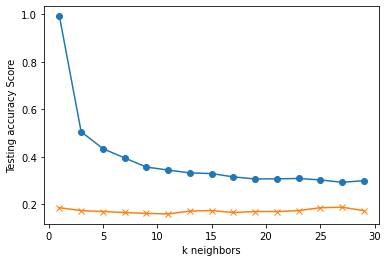

In [74]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 30, 2), train_scores, marker='o')
plt.plot(range(1, 30, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [75]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_scaled, y_train)
print('k=15 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=15 Test Acc: 0.174


In [76]:
knn.score(X_train_scaled, y_train)

0.3299933199732799

In [77]:
# Predicting show using KNN and user input
user_entry = [[8, 45, 35, 30, 60, 9]]
predicted_network_knn = knn.predict(user_entry)
print(le.inverse_transform(predicted_network_knn))

['NBC']


In [78]:
# Predicting show using Random Forest Hypertuned Model
user_entry = [[8, 45, 35, 30, 60, 9]]
predicted_network = model.predict(user_entry)
print(le.inverse_transform(predicted_network))

['HBO']


In [79]:
# Predicting show using Random Forest Hypertuned Model
user_entry = [[8, 45, 35, 30, 60, 9]]
predicted_network_et = model_et.predict(user_entry)
print(le.inverse_transform(predicted_network))

['HBO']


In [80]:
# Save network predictor Model
import joblib
joblib.dump(model_et,"network_predictor.joblib")

['network_predictor.joblib']